In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..

C:\Users\Dimitri\workspaces\opensource\quantum-machine-learning


C:\Users\Dimitri\anaconda3\envs\quantum-machine-learning\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from penny.classifier import BinaryClassifier
from penny.models import StronglyEntangledBinaryModel, amplitude_embedding_fn
from utils.embeddings import *
from utils.reporting import HistoryTracker

import pandas as pd

In [4]:
def run_experiment(X_train, X_test, y_train, y_test, projection_fn, label):
    X_train_scaled = np.apply_along_axis(projection_fn, 1, X_train)
    X_test_scaled = np.apply_along_axis(projection_fn, 1, X_test)

    history_tracker = HistoryTracker(X_train_scaled, y_train)

    num_qubits = 5
    num_layers = 3
    model = StronglyEntangledBinaryModel(num_qubits, embedding_fn=amplitude_embedding_fn)
    classifier = BinaryClassifier(model=model,
                                  weights_shape=(num_layers, num_qubits, 3),
                                  device="lightning.qubit",
                                  iterations=150,
                                  report_fn=history_tracker)
    classifier.fit(X_train_scaled, y_train)
    cr = evaluate(classifier, X_test_scaled, y_test)
    print(f'Performance results for {label}')
    print(cr)
    return classifier, history_tracker

In [5]:
def evaluate(classifier, features, labels):
    predictions_test = classifier.predict(features)
    return classification_report(labels, predictions_test)

In [6]:
def plot_training_history(trackers, columns):
    histories = [tracker.history for tracker in trackers]
    df = pd.DataFrame(list(zip(*histories)), columns=columns)
    df.plot(title='Performance comparison for Amplitude Embedding')

In [7]:
seed = 31821
np.random.seed(seed)

features, y = load_breast_cancer(return_X_y=True)
X = StandardScaler().fit_transform(features)
y[y == 0] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=seed)


In [8]:
import functools
inverse_gnomonic_projection = functools.partial(arbitrary_inverse_projection, 0)
inverse_twilight_projection = functools.partial(arbitrary_inverse_projection, -1-np.sqrt(2)/2)

In [9]:
projections = [inverse_stereographic_projection,
                   inverse_gnomonic_projection,
                   inverse_twilight_projection]
labels = ['Stereographic', 'Gnomonic', 'Twilight']

classifiers = []
trackers = []
for projection, label in zip(projections, labels):
    classifier, tracker = run_experiment(X_train, X_test, y_train, y_test, projection, label)
    classifiers.append(classifier)
    trackers.append(tracker)


Iter:    10 | Accuracy: 0.6395604 
Iter:    20 | Accuracy: 0.6483516 
Iter:    30 | Accuracy: 0.9054945 
Iter:    40 | Accuracy: 0.8395604 
Iter:    50 | Accuracy: 0.9208791 
Iter:    60 | Accuracy: 0.9010989 
Iter:    70 | Accuracy: 0.9186813 
Iter:    80 | Accuracy: 0.9010989 
Iter:    90 | Accuracy: 0.9230769 
Iter:   100 | Accuracy: 0.9340659 
Iter:   110 | Accuracy: 0.8659341 
Iter:   120 | Accuracy: 0.8637363 
Iter:   130 | Accuracy: 0.9164835 
Iter:   140 | Accuracy: 0.9164835 
Iter:   150 | Accuracy: 0.9318681 
Performance results for Stereographic
              precision    recall  f1-score   support

          -1       1.00      0.83      0.91        48
           1       0.89      1.00      0.94        66

    accuracy                           0.93       114
   macro avg       0.95      0.92      0.93       114
weighted avg       0.94      0.93      0.93       114

Iter:    10 | Accuracy: 0.6395604 
Iter:    20 | Accuracy: 0.6681319 
Iter:    30 | Accuracy: 0.6813187 
Iter:

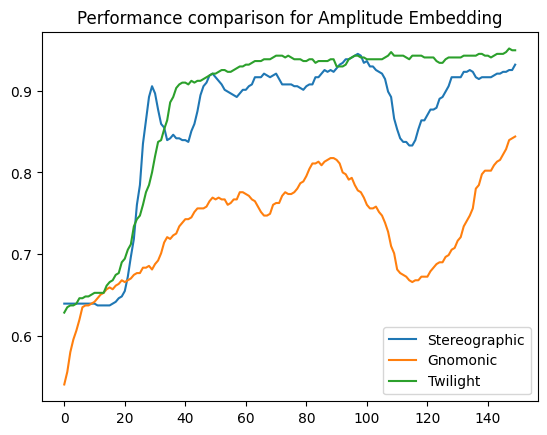

In [10]:
plot_training_history(trackers, columns=labels)